In [1]:
# Imports 
import numpy as np
import pandas as pd

import tensorflow as tf

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

import matplotlib.pyplot as plt

In [2]:
# Pricing models
import scipy.stats as si
class Black_Scholes():
    def __init__(self,interest= 0.04,volatility = 0.22, maturity = 0.4, strike = 50):
        self.r = interest
        self.sigma = volatility
        self.T = maturity
        self.K = strike
    def price(self,S,tau_):
        d1 = (np.log(S / self.K) + (self.r + 0.5 * self.sigma ** 2) * tau_) / (self.sigma * np.sqrt(tau_))
        d2 = (np.log(S / self.K) + (self.r - 0.5 * self.sigma ** 2) * tau_) / (self.sigma * np.sqrt(tau_))
        call = (S * si.norm.cdf(d1, 0.0, 1.0) - self.K * np.exp(-self.r * tau_) * si.norm.cdf(d2, 0.0, 1.0))

        return call
    def delta(self,S,tau_):    
        d1 = (np.log(S / self.K) + (self.r + 0.5 * self.sigma ** 2) * tau_) / (self.sigma * np.sqrt(tau_))  
        delta_call = si.norm.cdf(d1, 0.0, 1.0)
        
        return delta_call
    def theta(self,S,tau_):    
        d1 = (np.log(S / self.K) + (self.r + 0.5 * self.sigma ** 2) * tau_) / (self.sigma * np.sqrt(tau_))
        d2 = (np.log(S / self.K) + (self.r - 0.5 * self.sigma ** 2) * tau_) / (self.sigma * np.sqrt(tau_))
        prob_density = 1 / np.sqrt(2 * np.pi) * np.exp(-d1 ** 2 * 0.5)
        theta_call = (-self.sigma * S * prob_density) / (2 * np.sqrt(tau_)) - self.r * self.K * np.exp(-self.r * tau_)\
            * si.norm.cdf(d2, 0.0, 1.0)

        return theta_call
class LVM():
    def __init__(self,interest= 0.05, maturity = 0.4, strike = 50):
        self.r = interest
        self.T = maturity
        self.K = strike
    def sigma(self,t,S,S_star):
        if np.abs(np.log(S,S_star))< 0.4:
            sigma_ = 0.4 - 0.16 * np.exp(-0.5*(self.T-t))*np.cos(1.25*np.pi * np.log(S,S_star))
        else:
            sigma_ = 0.4
        return sigma_ 

In [3]:
# Custom positive semidefinite kernel
class CustomKernel(psd_kernels.PositiveSemidefiniteKernel):
    def __init__(self,feature_ndims=1, parameters=None,dtype=None, name='Custom_Kernel', validate_args=False):
        super().__init__(feature_ndims, dtype, name, validate_args, parameters)
        self.amplitude = parameters['amp']
        self.length_scales = parameters['scales']
        self.family = parameters['family']
    def _apply(self,x,y,example_ndims):
        scaled_diff = (x-y)/self.length_scales
        if (self.family == 'M52'): return self._apply_M52(scaled_diff)
        if (self.family == 'M32'): return self._apply_M32(scaled_diff)
        return self._apply_SE(scaled_diff)
    
    def _apply_SE(self,diff):
        return self.amplitude*tf.exp(-tf.math.reduce_sum(diff**2/2,axis=-1))
    
    def _apply_M52(self,diff):
        prod_element = (1+np.sqrt(5)*diff+5*(diff**2)/3)*tf.math.exp(-np.sqrt(5)*tf.math.abs(diff))
        return self.amplitude*tf.reduce_prod(prod_element,axis=-1)
        
    def _apply_M32(self,diff):
        prod_element = (1+np.sqrt(3)*diff)*tf.math.exp(-np.sqrt(3)*diff)
        return self.amplitude*tf.reduce_prod(prod_element,axis=-1)
    
    def _batch_shape(self):
        scalar_shape = tf.TensorShape([])
        return scalar_shape

    def _batch_shape_tensor(self):
        return tf.convert_to_tensor(self.batch_shape, dtype=tf.int32, name='batch_shape')

In [4]:
# Functions generating training and test data

def training_data(pricing_model,tau_,stock_):
    grid = [(t,s) for t in tau_ for s in stock_]
    grid = np.asarray(grid)
    
    prices = pricing_model.price(grid[:,1],grid[:,0])
    deltas = pricing_model.delta(grid[:,1],grid[:,0])
    
    df_train = pd.DataFrame(data=[grid[:,0],grid[:,1],prices,deltas]).T
    df_train.columns=['Tau','Stock','Price','Delta']
    
    X_ = tf.constant(df_train.iloc[:,:2],dtype =tf.float64)
    y_ = tf.constant(df_train.iloc[:,2],dtype=tf.float64)
    return X_, y_

def test_data(pricing_model,tau,stock_):
    tau_slice = tau*np.ones(len(stock_))
    x_test = np.vstack([tau_slice,test_stocks]).T
    y_test = pricing_model.price(stock_,tau_slice)
    
    return x_test, y_test

In [5]:
class GP_model(tfp.distributions.GaussianProcess):
    def __init__(self,kernel, index_points=None, mean_fn=None,beta = (), observation_noise_variance=0.0,\
                jitter=1e-06, validate_args=False, allow_nan_stats=False, name='GP'):
        super().__init__(kernel, index_points, mean_fn, observation_noise_variance,jitter, validate_args, allow_nan_stats, name)
        self.hyperparam = self.trainable_variables + beta
    @tf.function
    def optimize(self,y_,optimizer):        
        with tf.GradientTape() as tape:
            loss = -self.log_prob(y_)
        grads = tape.gradient(loss, self.hyperparam)
        optimizer.apply_gradients(zip(grads, self.hyperparam))
        del tape
        return loss
    
    def fit(self,y_,optimizer = tf.optimizers.Adam(),n_iters = 2000, verbose = True):
        for i in range(n_iters):
            neg_log_likelihood = self.optimize(y_,optimizer)
            if i % 200 == 0 and verbose:
                print("Step {}: NLL = {}".format(i, neg_log_likelihood))
        print("Final NLL = {}".format(neg_log_likelihood))

class GPR_model(tfp.distributions.GaussianProcessRegressionModel):
    def __init__(self,kernel,index_points = None ,observation_index_points = None ,observations = None,\
                observation_noise_variance = 0.0,predictive_noise_variance=None, mean_fn=None,\
                jitter=1e-06, validate_args=False, allow_nan_stats=False,name='GPR_Model'):
        
        super().__init__(kernel, index_points, observation_index_points, observations,\
                        observation_noise_variance, predictive_noise_variance, mean_fn,jitter, validate_args, allow_nan_stats,name)
        self.prior_kernel = kernel
    def price(self): return self.mean()
    
    def gradient(self):
        with tf.GradientTape() as tape:
            tape.watch(self.index_points)
            p_hat = self.price()
        grad = tape.gradient(p_hat,self.index_points)
        del tape
        return grad
    
    def delta(self): return self.gradient()[:,-1]    
    def theta(self): return -self.gradient()[:,0]
    
    def ddk_dS2(self,x_,y_,i = 1):
        l = self.prior_kernel.length_scales[i]
        return (1-1/l**2*(x_[:,i]-y_[:,i])**2)/l**2*self.prior_kernel.tensor(x_,y_,1,1)
    @tf.function
    def K_g(self,stock = True): 
        dim = len(self.observation_index_points)
        inverse_matrix = tf.linalg.inv(self.prior_kernel.tensor(self.observation_index_points,self.observation_index_points,1,1)\
                    + self.observation_noise_variance*tf.eye(dim,dtype=tf.float64))
        with tf.GradientTape() as tape:
            tape.watch(self.index_points)
            kappa = self.prior_kernel.matrix(self.index_points,self.observation_index_points)
        jac = tape.batch_jacobian(kappa,self.index_points)
        
        if stock: dkappa = jac[:,:,-1]
        else : dkappa = jac[:,:,0]
        term1 = self.ddk_dS2(self.index_points,self.index_points,0+stock)
        term2 = dkappa@inverse_matrix@tf.transpose(dkappa)
        
        return term1 - term2
    
    def V_g(self,stock = True):
        i = stock + 0
        temp1 = tf.identity(self.index_points)
        temp2 = tf.identity(self.index_points)
        with tf.GradientTape() as tape2:
            tape2.watch(temp2)
            with tf.GradientTape() as tape1:
                tape1.watch(temp1)
                K_star = self.kernel.apply(temp1, temp2)
            dK_star = tape1.gradient(K_star, temp1)[:,i]
        d2K_star = tape2.gradient(dK_star, temp2)[:,i]
        return d2K_star
    
    def bounds_price(self,confidence):
        z = si.norm.ppf((confidence+1)/2)
        return self.mean() - z*np.sqrt(self.variance()), self.mean() + z*np.sqrt(self.variance())
    
    def bounds_delta(self,confidence):
        z = si.norm.ppf((confidence+1)/2)
        return self.delta() - z*np.sqrt(self.V_g()), self.delta() + z*np.sqrt(self.V_g())

    def bounds_theta(self,confidence):
        z = si.norm.ppf((confidence+1)/2)
        return self.theta() - z*np.sqrt(self.V_g(False)), self.theta() + z*np.sqrt(self.V_g(False))
    
    def plot_price(self,true_price,bounds = True,confidence = 0.95):
        lBound , uBound = self.bounds_price(confidence)
        return self.plot(self.price(),true_price,bounds,confidence,lBound,uBound)
    
    def plot_delta(self,true_delta,bounds= True,confidence = 0.95):
        lBound , uBound = self.bounds_delta(confidence)
        return self.plot(self.delta(),true_delta,bounds,confidence,lBound,uBound)
    
    def plot_theta(self,true_theta,bounds= True,confidence = 0.95):
        lBound , uBound = self.bounds_theta(confidence)
        return self.plot(self.theta(),true_theta,bounds,confidence,lBound,uBound)
    
    def plot(self,true_values,y_pred,bounds,confidence,u_bound,l_bound):
        test_stocks = self.index_points[:,-1]
        lBound = l_bound
        uBound = u_bound
        plt.plot(test_stocks,true_values)
        plt.scatter(test_stocks,y_pred,color='red')
        if bounds:
            plt.plot(test_stocks,lBound,'--',color='black',linewidth=1)
            plt.plot(test_stocks,uBound,'--',color='black',linewidth=1)
        plt.show()

In [6]:
class GPR_analytical():
    def __init__(self,kernel,data,labels,mean_fn,noise,test_data=None):
        self.kernel = kernel
        self.X = data
        self.y = labels
        self.mean_fn = mean_fn
        self.sigma = noise
        self.X_test = test_data
        self.inv_matrix = tf.linalg.inv(self.kernel.tensor(data,data,1,1)+\
                                        noise*tf.eye(len(data),dtype=tf.float64))
        self.K = self.kernel.matrix(test_data,data)
        
    def set_test_data(self,test_data):
        self.X_test = test_data
        self.K = self.kernel.matrix(test_data,self.X)
        
    def price(self):
        term_1 = self.mean_fn(self.X_test)
        term_2 = self.K@self.inv_matrix@tf.reshape((self.y-self.mean_fn(self.X)),[len(y),1])
        
        return term_1 + tf.squeeze(term_2)
    
    def covariance(self):
        term_1 = self.kernel.matrix(self.X_test,self.X_test)      
        term_2 = self.K@self.inv_matrix@tf.transpose(self.K)
        
        return term_1-term_2
    
    def variance(self): return tf.linalg.diag_part(self.covariance())
    
    def dk_dS(self,x_,y_):
        reshaped = tf.transpose(tf.broadcast_to(y_[:,-1],[len(x_),len(y_)]))
        l_stock = self.kernel.length_scales[-1]
        
        return tf.transpose((reshaped-x_[:,-1]))/l_stock**2\
                *self.kernel.tensor(x_,y_,1,1)
    
    def dk_dt(self,x_,y_):
        reshaped = tf.transpose(tf.broadcast_to(y_[:,0],[len(x_),len(y_)]))
        l_time = self.kernel.length_scales[0]
        return tf.transpose((reshaped-x_[:,0]))/l_time**2\
                *self.kernel.tensor(x_,y_,1,1)
    
    def delta(self):
        b_1 = self.mean_fn(np.array([[0.,1.]]))-self.mean_fn(np.array([[0.,0.]]))
        term_2 = self.dk_dS(self.X_test,self.X)@self.inv_matrix@\
                tf.reshape((self.y-self.mean_fn(self.X)),[len(y),1])
        
        return tf.squeeze(b_1+term_2)
    
    def theta(self):
        term_2 = self.dk_dt(self.X_test,self.X)@self.inv_matrix@\
                tf.reshape((self.y-self.mean_fn(self.X)),[len(y),1])
        return -tf.squeeze(term_2)
    
    def ddk_dS2(self,x_,y_):
        l_stock = self.kernel.length_scales[-1]
        coef = (1-1/l_stock**2*(x_[:,-1]-y_[:,-1])**2)/l_stock**2
        return coef*self.kernel.tensor(x_,y_,1,1)
    
    def K_g(self):
        term_1 = self.ddk_dS2(self.X_test,self.X_test)
        term_2 = self.dk_dS(self.X_test,self.X)@self.inv_matrix@tf.transpose(self.dk_dS(self.X_test,self.X))
        
        return term_1 - term_2
    def V_g(self): return tf.linalg.diag_part(self.K_g())
    
    def upper_bound(self,confidence):
        z = si.norm.ppf((confidence+1)/2)
        return self.delta() + z*np.sqrt(self.V_g())
    def lower_bound(self,confidence):
        z = si.norm.ppf((confidence+1)/2)
        return self.delta() - z*np.sqrt(self.V_g())
    
    def plot_price(self,true_price,confidence=0.95,bounds=True):
        test_stocks = self.X_test[:,-1]
        plt.plot(test_stocks,true_price)
        plt.scatter(test_stocks,self.price(),marker = 'o',color='red')
#         if bounds:
#             plt.plot(test_stocks,self.upper_bound(confidence),'--',color='black',linewidth = 1)
#             plt.plot(test_stocks,self.lower_bound(confidence),'--',color='black',linewidth = 1)
        plt.show()
    
    def plot_delta(self,true_delta,confidence=0.95,bounds=True):
        test_stocks = self.X_test[:,-1]
        plt.plot(test_stocks,true_delta)
        plt.scatter(test_stocks,self.delta(),marker = 'o',color='red')
        if bounds:
            plt.plot(test_stocks,self.upper_bound(confidence),'--',color='black',linewidth = 1)
            plt.plot(test_stocks,self.lower_bound(confidence),'--',color='black',linewidth = 1)
        plt.show()

In [ ]:
T=0.4
S_min = 30
S_max = 70
t_space = np.linspace(0,0.4,20)
S_space = np.linspace(30, 70, 20)

space = []
for t in t_space:
    for S in S_space:
        space.append([t, S])

#50 virtual data points
for S in [71,72]:
    for t in np.linspace(0,T,10):
        space.append([t,S])
for S in [28,29]:
    for t in np.linspace(0,T,10):
        space.append([t,S])
for S in np.linspace(S_min,S_max,10):
    for t in [T]:
        space.append([t,S])
        
space_frame = pd.DataFrame(space,columns=['t', 'S'])
space_frame.head()
tau = np.array(space_frame.iloc[:,0])
stock = np.array(space_frame.iloc[:,1])

X = np.zeros([450,2])
X[:,0] = tau
X[:,1] = stock

In [16]:
#Define pricing model and training data grid 
bs_model = Black_Scholes()
stock = np.linspace(32,68,10,dtype=np.float64)
tau = np.linspace(0.04,0.4,10,dtype= np.float64)
X,y = training_data(bs_model,tau,stock)

#Define trainable variables
b0 = tf.Variable(-15,dtype=tf.float64, name = 'b0')
b = tf.Variable([[1,1]],dtype=tf.float64, name= 'b12')
b1 = tf.Variable([1],dtype=tf.float64, name= 'b1')
b2 = tf.Variable([1],dtype=tf.float64, name= 'b2')

process_variance = 100#237
noise_variance = 0.0001
length_scales = [0.3,5]#[0.626,10]

sp = tf.Variable(process_variance,dtype=tf.float64, name = 'sigma_process')
sn2 = tf.Variable(noise_variance,dtype=tf.float64,name = 'sigma_noise2',constraint= lambda x: x**2)
scales = [tf.Variable(length_scales[0],dtype=tf.float64 ,name = 'l1'),tf.Variable(length_scales[1],dtype=tf.float64 ,name = 'l2')]

#Define custom kernel
kernel_family = 'SE'
param ={'amp' : sp , 'scales': scales,'family' : kernel_family}
my_kernel = CustomKernel(1,parameters = param)


def mean_f(x): return tf.squeeze(b0 + tf.linalg.matmul(x, b, transpose_b=True))
def mean_f(x): return b0 + b1*x[:,0] + b2*x[:,-1]

In [17]:
#Define test data
test_stocks = np.linspace(34,62,25)
tau = 0.2
X_test, y_test = test_data(bs_model,tau,test_stocks)
delta_test = bs_model.delta(test_stocks,tau)
theta_test = bs_model.theta(test_stocks,tau)
#test_stocks

In [18]:
#Define and fit the model
GP = GP_model(my_kernel, index_points=X,mean_fn=mean_f, beta=(b0,b1,b2),observation_noise_variance=1e-4,jitter=1e-06, name='GP')
GP.fit(y,n_iters=2000,verbose=True,optimizer = tf.optimizers.Adam(0.01))

Step 0: NLL = -93.65410928668071
Step 200: NLL = -188.6190684156958
Step 400: NLL = -188.8513347066568
Step 600: NLL = -189.0062061261014
Step 800: NLL = -189.15936028467496
Step 1000: NLL = -189.31939696464357
Step 1200: NLL = -189.48674486602405
Step 1400: NLL = -189.66101255949587
Step 1600: NLL = -189.8419249348015
Step 1800: NLL = -190.02933242007848
Final NLL = -190.22218296048368


In [21]:
GP.hyperparam

(<tf.Variable 'sigma_process:0' shape=() dtype=float64, numpy=80.46416376448481>,
 <tf.Variable 'l1:0' shape=() dtype=float64, numpy=0.9177395992145404>,
 <tf.Variable 'l2:0' shape=() dtype=float64, numpy=5.824409400945904>,
 <tf.Variable 'b0:0' shape=() dtype=float64, numpy=-17.337296767221318>,
 <tf.Variable 'b1:0' shape=(1,) dtype=float64, numpy=array([2.21961678])>,
 <tf.Variable 'b2:0' shape=(1,) dtype=float64, numpy=array([0.46687263])>)

In [19]:
#Define a GP Regression model with learned parameters
GPR = GPR_model(my_kernel,X_test,X,y,observation_noise_variance=sn2,predictive_noise_variance=None,mean_fn=mean_f,jitter=1e-6)
aGPR = GPR_analytical(my_kernel,X,y,mean_f,sn2,X_test)

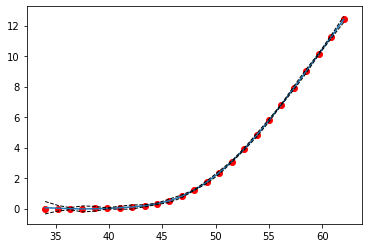

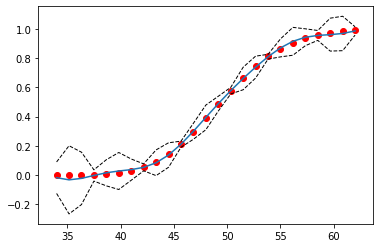

In [20]:
GPR.plot_price(y_test,bounds=True)
GPR.plot_delta(delta_test,bounds=True)
#aGPR.plot_delta(delta_test)

In [22]:
#Data from section 2.5 in paper
new_sp = tf.Variable(239.71,dtype=tf.float64)
new_scales = tf.Variable([0.626,10],dtype=tf.float64)
new_sn = tf.Variable(1.99e-04,dtype=tf.float64)
new_b0 = tf.constant(-20.04,tf.float64)
new_b1 = tf.constant(0.58,tf.float64)
new_kernel = CustomKernel(1,parameters={'amp': new_sp, 'scales': new_scales,'family':'SE'})
def new_mean_f(x): return new_b0 + new_b1 * x[:,-1]
def const_mean(x): return 0

aGPR = GPR_analytical(new_kernel,X,y,new_mean_f,new_sn,X_test)
the_GPR = GPR_model(new_kernel,X_test,X,y,new_sn,mean_fn=new_mean_f,predictive_noise_variance=None,jitter = 1e-6)

In [ ]:
XX = tf.constant(X_test,dtype=tf.float64)
a = tf.identity(XX)#XX[0:2,:]
b= tf.identity(XX)#[0:2,:]

a = XX[0,:]
b = XX[1,:]

with tf.GradientTape() as gg:
    gg.watch(b)
    with tf.GradientTape() as g:
        g.watch(a)
        K_0 = the_GPR.kernel.apply(a,b)
    dy_dx = g.gradient(K_0, a)[-1]
d2y_dx2 = gg.gradient(dy_dx, b)

#dy_dx[:,:,-1]
print(dy_dx)
d2y_dx2#[:,:,-1]

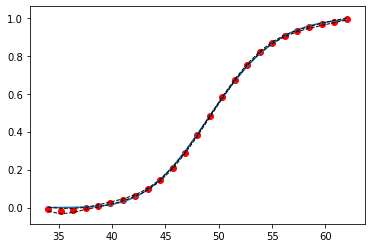

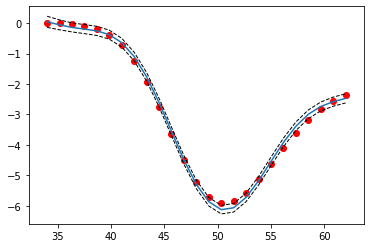

In [27]:
aGPR.plot_delta(delta_test,bounds = True)

the_GPR.plot_theta(theta_test)

In [ ]:
GPP = GP_model(new_kernel,X,observation_noise_variance=new_sn)
GPP.log_prob(y)